In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

In [21]:
data_train = pd.read_csv("poly_regression_small.csv")
data_test = pd.read_csv("poly_regression_large.csv")

Xtrain, Ytrain = data_train["x"], data_train["y"]


print(f"Xtrain shape: {Xtrain.shape}")
print(f"Ytrain shape: {Ytrain.shape}")

Xtrain shape: (50,)
Ytrain shape: (50,)


In [25]:
data_test = pd.read_csv("poly_regression_large.csv")
data_shuffled = data_test.sample(frac=1, random_state=42)  #Shuffle the data
Xtest = data_shuffled["x"]
Ytest = data_shuffled["y"]

test_size = int(0.8 * len(Xtest))
Xtest = Xtest[test_size:]
Ytest = Ytest[test_size:]

#Because of the index problem in the SGD function
#It resets the index without conserving it as column
Xtest = Xtest.reset_index(drop=True)
Ytest = Ytest.reset_index(drop=True)

print(f"Xtest shape: {Xtest.shape}")
print(f"Ytest shape: {Ytest.shape}")

Xtest shape: (200,)
Ytest shape: (200,)


In [11]:
##FUNCTIONS

def f(x,theta):
    y = 0
    for j in range(len(theta)):
        y = y + theta[j] * x**j
    return y

def vandermonde(x,K):
    N = x.shape[0]
    PhiX = np.zeros((N,K))
    for j in range(K):
        PhiX[:, j]= x**j
    return PhiX

def loss(theta, X, y):
    k = len(theta)
    PhiX = vandermonde(X,k)
    y_pred = PhiX @ theta
    error = y_pred - y
    error_norm = np.linalg.norm(error, 2)**2
    return error_norm/2

def grad_loss(theta, X, y):
    k = len(theta)
    PhiX = vandermonde(X,k) #Nxk
    y_pred = PhiX @ theta #Nx1
    error = y_pred - y 
    grad = PhiX.T @ error #Kx1 
    return grad 

In [12]:
##Stochastic Gradient Descent

def SGD(loss, grad_loss, X, Y, theta0, alpha, batch_size, n_epochs):
    X = X
    y = Y
    N = X.shape[0] # We assume both X and Y has shape (N, )
    d = theta0.shape[0] # While theta0 has shape (d, )
    idx = np.arange(0, N) # This is required for the shuffling
    
    # Initialization of history vectors
    theta_history = np.zeros((n_epochs, d))  # Save parameters at each epoch 
    loss_history = np.zeros((n_epochs, ))  # Save loss values at each epoch
    grad_norm_history = np.zeros((n_epochs, ))  # Save gradient norms at each epoch
    
    # Initialize weights
    theta = theta0
    for epoch in range(n_epochs):
        # Shuffle the data at the beginning of each epoch
        np.random.shuffle(idx)
        X = Xtrain[idx]
        y = Ytrain[idx]

        # Initialize a vector that saves the gradient of the loss at each iteration
        grad_loss_vec = []

        for batch_start in range(0, N, batch_size):
            batch_end = min(batch_start + batch_size, N)
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]
            
            # Compute the gradient of the loss
            gradient = grad_loss(theta, X_batch, y_batch)
            grad_loss_vec.append(np.linalg.norm(gradient, 2))

            # Update weights
            theta = theta - alpha * gradient

        # Save the updated values
        theta_history[epoch] = theta
        loss_history[epoch] = loss(theta, X, y)
        grad_norm_history[epoch] = np.mean(grad_loss_vec)
    
    return theta_history, loss_history, grad_norm_history

In [13]:
#Gradient Descent

def GD(grad_loss, X, y,  theta0, alpha, kmax = 100, tolf= 1e-6, tolx= 1e-6, backtrack = False):
    grad_norm = np.zeros((kmax+1, ))
    grad_norm[0] = np.linalg.norm(grad_loss(theta0, X, y))
    
       
    alphavalues = []
    for k in range(kmax):
        
        theta = theta0 - alpha * grad_loss(theta0,X,y)
        
        grad_norm[k+1] = np.linalg.norm(grad_loss(theta, X, y))
        
        if np.linalg.norm(grad_loss(theta, X, y)) <= tolf * grad_norm[0]:
            print(f"Break because of tolf at the {k} iteration")
            break
        elif np.linalg.norm(grad_loss(theta, X, y))<= tolx:
            print("Break because of tolx")
            break
        
        
        theta0 = theta
    #cut off the exceeding values
    grad_norm = grad_norm[:k+1]
    
    return theta, k, grad_norm, alphavalues

Computed theta with SGD: [-0.07120577  0.65698031  2.80293742  0.38422404 -2.74713783]


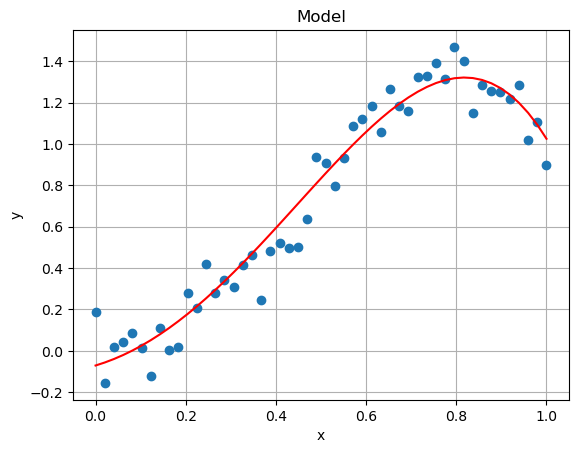

In [14]:
theta0 = np.zeros((5,))
result_SGD = SGD(loss, grad_loss, Xtrain, Ytrain, theta0, 0.05, 20, 1000)
computed_theta_SGD = result_SGD[0][-1]
print(f"Computed theta with SGD: {computed_theta_SGD}")

plt.plot(Xtrain, Ytrain, 'o')
plt.plot(Xtrain, f(Xtrain,computed_theta_SGD), 'r')
plt.title("Model")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

Computed theta with GD: [-0.17314467  1.56163461  1.38384131 -0.10039285 -1.57653863]


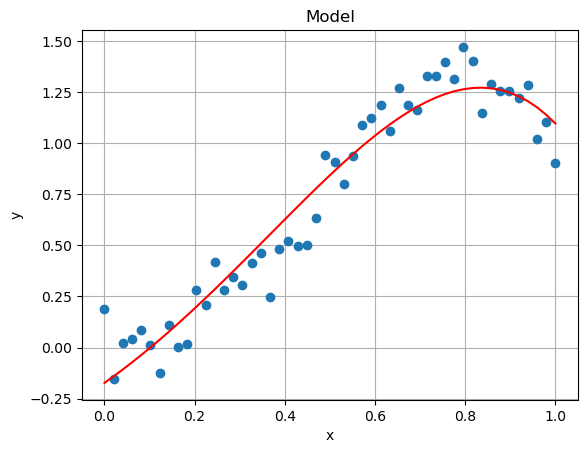

In [15]:
theta0 = np.zeros((5,))
result_GD = GD(grad_loss, Xtrain, Ytrain,  theta0, 0.001, kmax = 13000, tolf= 1e-6, tolx= 1e-6, backtrack = False)
computed_theta_GD = result_GD[0]
print(f"Computed theta with GD: {computed_theta_GD}")

plt.plot(Xtrain, Ytrain, 'o')
plt.plot(Xtrain, f(Xtrain,computed_theta_GD), 'r')
plt.title("Model")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

Computed theta with Normal Equation: [ 0.03290773 -0.45977277  4.84291477  0.1721476  -3.66058933]


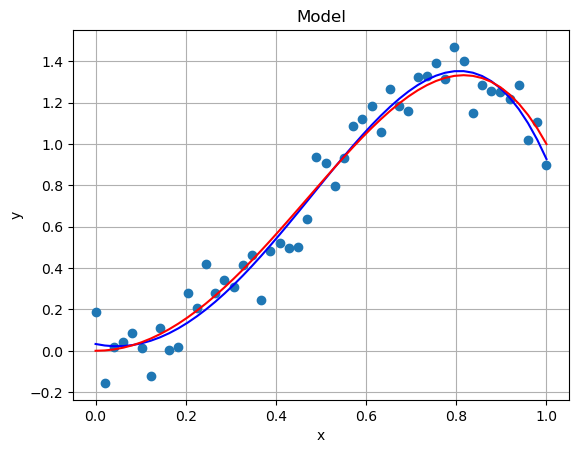

In [16]:
#I have to redfine the vandermonde function because with the old one, the matrix
#PhiX@PhiX.T wouldn't be Positive definite and so not factorizable into Cholesky
def vandermonde_NE(x,K):
    N = x.shape[0]
    PhiX = np.zeros((K,N))
    for j in range(K):
        PhiX[j, :]= x**j
    return PhiX

PhiX =  vandermonde_NE(Xtrain,K = 5)
L = np.linalg.cholesky(PhiX@PhiX.T)

z = np.linalg.solve(L, PhiX@Ytrain)

computed_theta_NorEq = np.linalg.solve(L.T, z)
theta_true = [0,0,4,0,-3]

def f(x,theta):
    y = 0
    for j in range(len(theta)):
        y = y + theta[j] * x**j
    return y


print(f"Computed theta with Normal Equation: {computed_theta_NorEq}")

plt.plot(Xtrain, Ytrain, 'o')
plt.plot(Xtrain, f(Xtrain,computed_theta_NorEq), 'b')
plt.plot(Xtrain, f(Xtrain,theta_true), 'r')
plt.title("Model")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

In [18]:
theta_values = {
    "computed_theta_SGD": computed_theta_SGD,
    "computed_theta_GD": computed_theta_GD,
    "computed_theta_NorEq": computed_theta_NorEq
}

for name, theta in theta_values.items():
    Ntest = len(Ytest)
    PhiX = vandermonde(Xtest, 5)
    
    y_pred = PhiX @ theta # (NxK) x (Kx1) = Nx1
    error = np.sum((y_pred - Ytest)**2) / Ntest
    print(f"Test set error using {name} is {error}")
    print(" ")

Test set error using computed_theta_SGD is 0.009244111883267825
 
Test set error using computed_theta_GD is 0.011776469363882608
 
Test set error using computed_theta_NorEq is 0.009618009288475868
 


In [19]:
def Normal_Eq(X, Y, k):
    PhiX =  vandermonde_NE(X, k)
    L = np.linalg.cholesky(PhiX@PhiX.T)

    z = np.linalg.solve(L, PhiX@Y)

    computed_theta_NorEq = np.linalg.solve(L.T, z)
    return computed_theta_NorEq


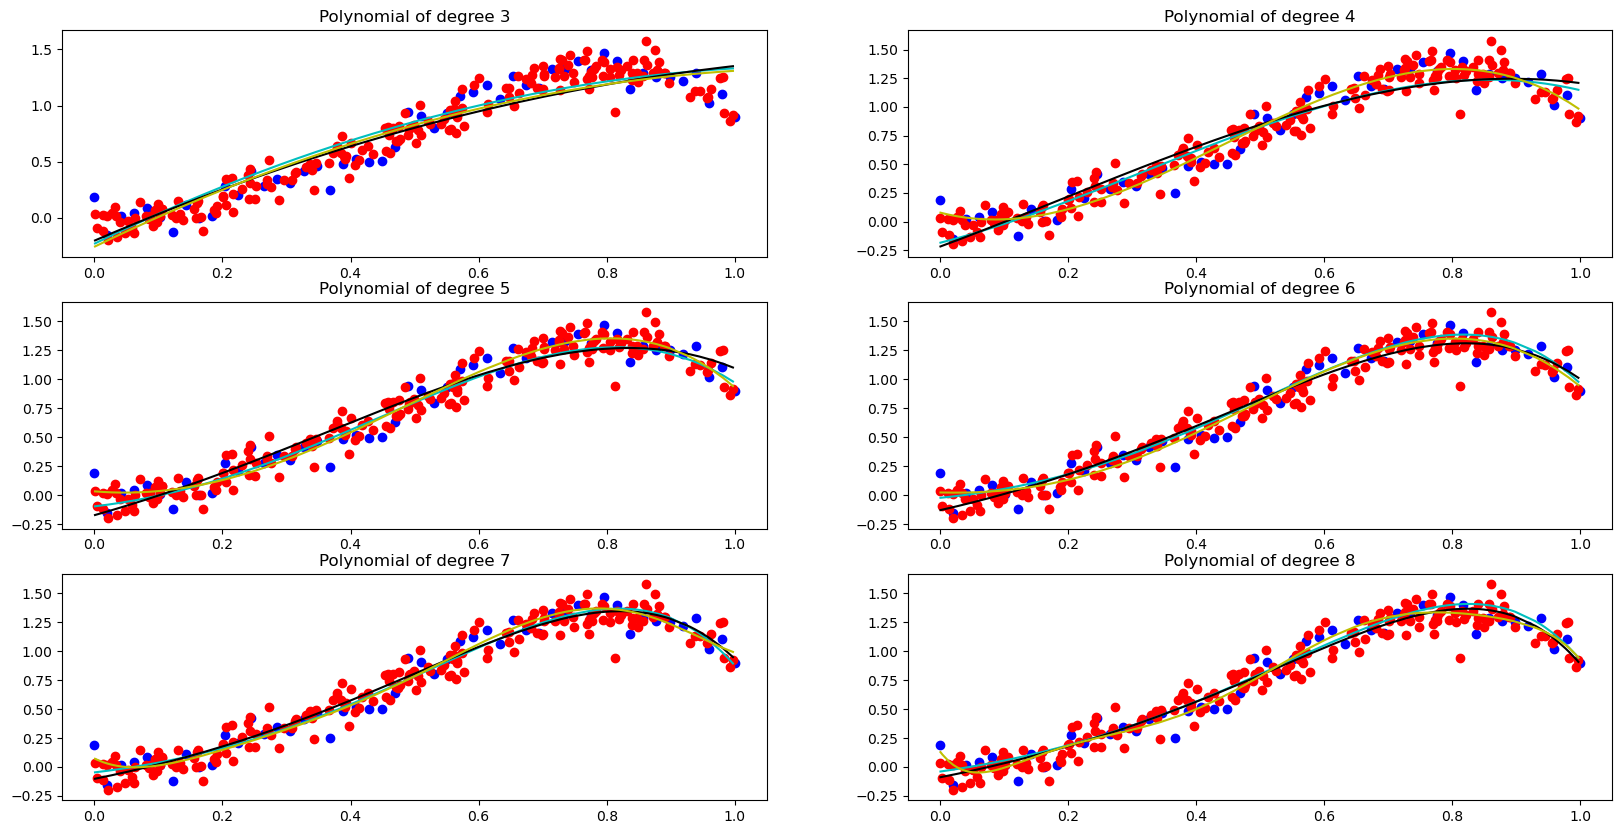

In [28]:
k_degrees = [3,4,5,6,7,8]
plt.figure(figsize=(20,10))
i = 1

for k in k_degrees:
    
    theta0 = np.zeros((k,))
    
    result_SGD = SGD(loss, grad_loss, Xtrain, Ytrain, theta0, 0.05, 20, 1000)
    computed_theta_SGD = result_SGD[0][-1]
    
    result_GD = GD(grad_loss, Xtrain, Ytrain,  theta0, 0.001, kmax = 13000, tolf= 1e-6, tolx= 1e-6, backtrack = False)
    computed_theta_GD = result_GD[0]
    
    computed_theta_NorEq = Normal_Eq(Xtrain, Ytrain, k)
    
    plt.subplot(3,2,i)
    plt.plot(Xtest, Ytest, 'o', color = "red", zorder = 2)
    plt.plot(Xtrain,Ytrain, 'o', color = "blue", zorder = 1)
    plt.plot(Xtest.sort_values(), f(Xtest.sort_values(), computed_theta_SGD), 'c', zorder = 5)
    plt.plot(Xtest.sort_values(), f(Xtest.sort_values(), computed_theta_GD), "k", zorder = 5)
    plt.plot(Xtest.sort_values(), f(Xtest.sort_values(), computed_theta_NorEq), "y", zorder = 5)
    plt.title(f"Polynomial of degree {k}")

    i += 1
    
plt.show()

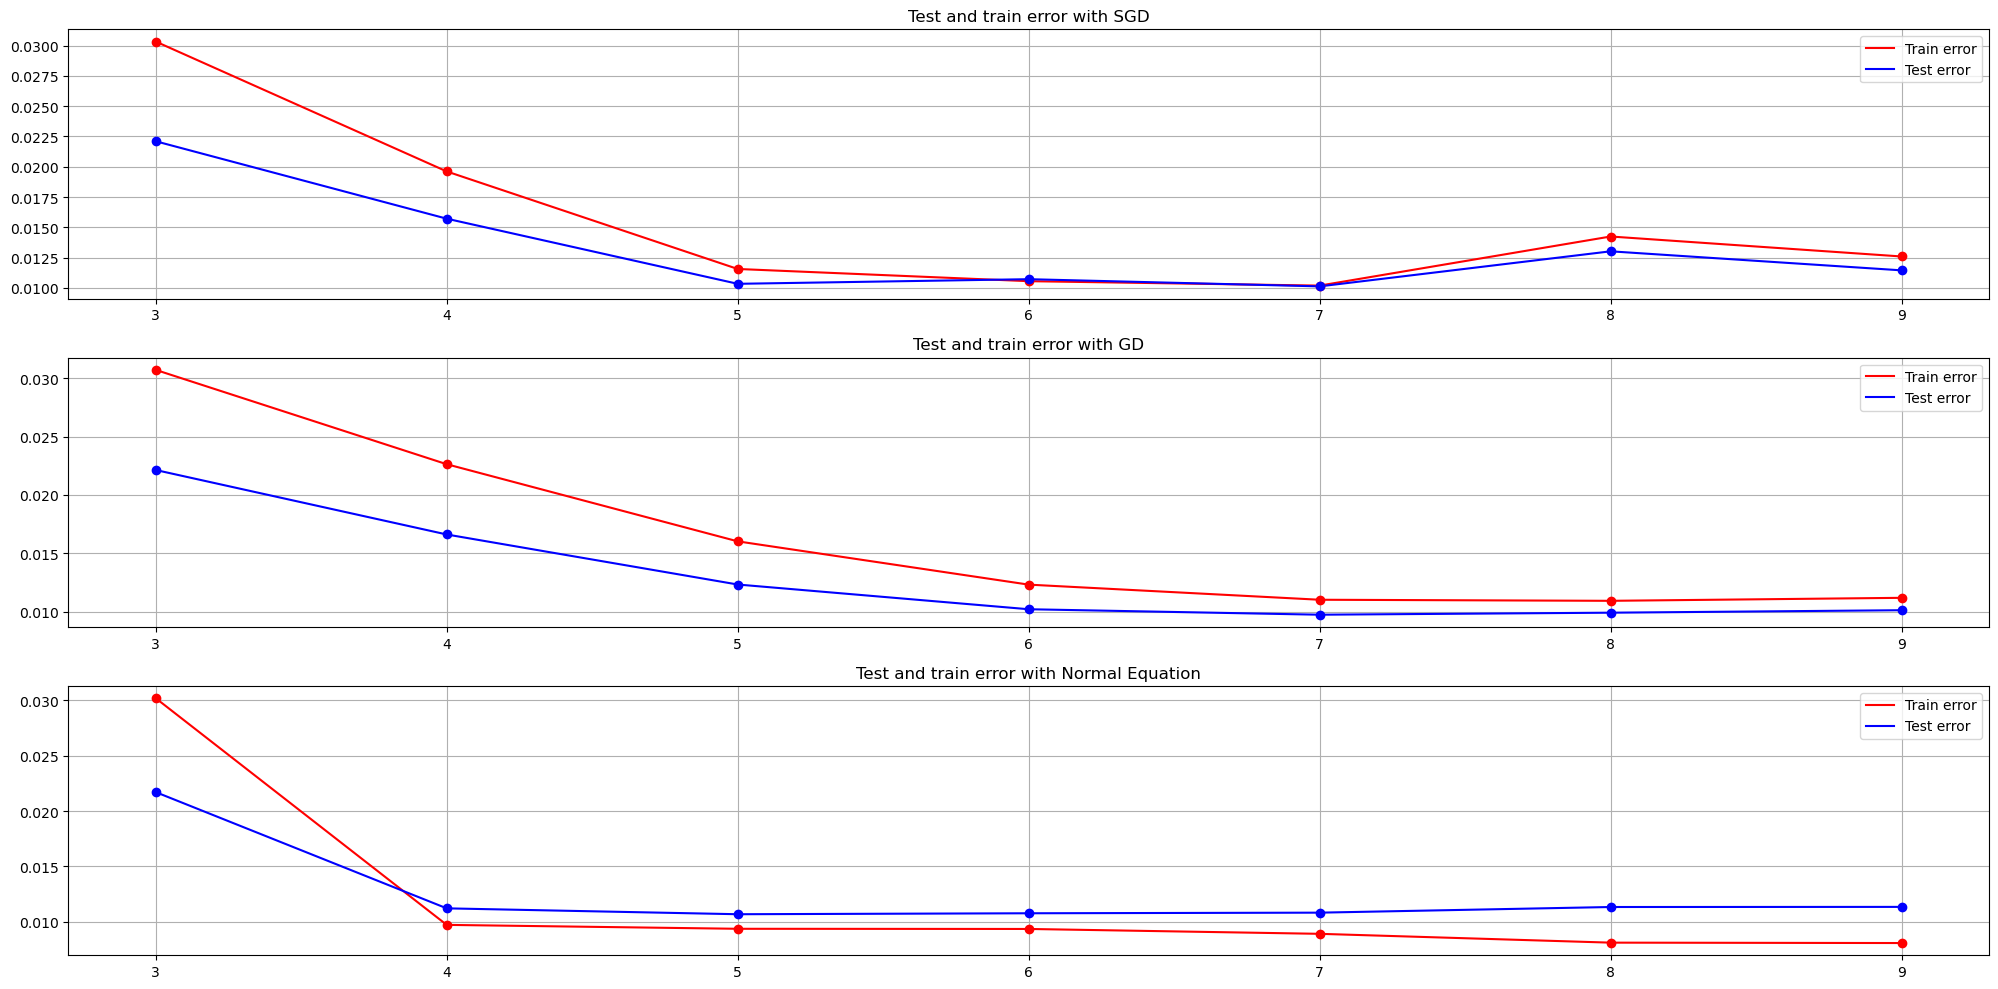

In [ ]:
k_degrees = [3,4,5,6,7,8,9] 
Ntest = len(Ytest)
Ntrain = len(Ytrain)

test_errors_SGD = []
test_errors_GD = []
test_errors_NorEq = []

train_errors_SGD = []
train_errors_GD = []
train_errors_NorEq = []

plt.figure(figsize=(20,10))

for k in k_degrees:
    theta0 = np.zeros((k,))
    
    result_SGD = SGD(loss, grad_loss, Xtrain, Ytrain, theta0, 0.05, 20, 1000)
    computed_theta_SGD = result_SGD[0][-1]
    
    result_GD = GD(grad_loss, Xtrain, Ytrain,  theta0, 0.001, kmax = 13000, tolf= 1e-6, tolx= 1e-6, backtrack = False)
    computed_theta_GD = result_GD[0]
    
    computed_theta_NorEq = Normal_Eq(Xtrain, Ytrain, k)
    
    PhiX_test = vandermonde(Xtest, k)
    PhiX_train = vandermonde(Xtrain, k)
    
    y_pred_test_SGD = PhiX_test @ computed_theta_SGD # (NxK) x (Kx1) = Nx1
    y_pred_test_GD = PhiX_test @ computed_theta_GD # (NxK) x (Kx1) = Nx1
    y_pred_test_NorEq = PhiX_test @ computed_theta_NorEq # (NxK) x (Kx1) = Nx1
    
    y_pred_train_SGD = PhiX_train @ computed_theta_SGD # (NxK) x (Kx1) = Nx1
    y_pred_train_GD = PhiX_train @ computed_theta_GD # (NxK) x (Kx1) = Nx1
    y_pred_train_NorEq = PhiX_train @ computed_theta_NorEq # (NxK) x (Kx1) = Nx1
    
    test_errors_SGD.append(np.sum((y_pred_test_SGD - Ytest)**2)/Ntest)
    test_errors_GD.append(np.sum((y_pred_test_GD - Ytest)**2)/Ntest)
    test_errors_NorEq.append(np.sum((y_pred_test_NorEq - Ytest)**2)/Ntest)
    
    train_errors_SGD.append(np.sum((y_pred_train_SGD - Ytrain)**2)/Ntrain)
    train_errors_GD.append(np.sum((y_pred_train_GD - Ytrain)**2)/Ntrain)
    train_errors_NorEq.append(np.sum((y_pred_train_NorEq - Ytrain)**2)/Ntrain)
    

plt.subplot(3,1,1)
plt.plot(k_degrees, train_errors_SGD, color = "r", label = "Train error")    
plt.plot(k_degrees, test_errors_SGD, color = "b", label = "Test error")
plt.scatter(k_degrees, train_errors_SGD, color="r", zorder=5)
plt.scatter(k_degrees, test_errors_SGD, color="b", zorder=5)    
plt.title("Test and train error with SGD")
plt.legend()
plt.grid()

plt.subplot(3,1,2)
plt.plot(k_degrees, train_errors_GD, color = "r", label = "Train error")    
plt.plot(k_degrees, test_errors_GD, color = "b", label = "Test error")
plt.scatter(k_degrees, train_errors_GD, color="r", zorder=5)
plt.scatter(k_degrees, test_errors_GD, color="b", zorder=5)  
plt.title("Test and train error with GD")
plt.legend()
plt.grid()
    

plt.subplot(3,1,3)
plt.plot(k_degrees, train_errors_NorEq, color = "r", label = "Train error")    
plt.plot(k_degrees, test_errors_NorEq, color = "b", label = "Test error")
plt.scatter(k_degrees, train_errors_NorEq, color="r", zorder=5)
plt.scatter(k_degrees, test_errors_NorEq, color="b", zorder=5)  
plt.title("Test and train error with Normal Equation")   
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()